## **README 27. February 2025**

The purpose of this notebook is to explore if the latest updates/chanegs to the DB of Pattison & Forshaw (2025) affects the results in any significant way. Between the main work on this project in 2023/24 and the publication of Pattison & Forshaw in 2025, minor changes and additions where done on the DB by Jacob.

# K-fold crossvalidation

This notebook uses k-fold (5-folds) crossvalidation to evaluate the performance of different models.\
The validation sets are 20% splits of the natural biotite composition database from Pattison and Forshaw (in prep).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from keras.models import load_model

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T, RMSE_denormalised_temperature_only
from ml_tb.validation import load_k_models, predict_on_val_set, RMSE, kfold_RMSE_PT, kfold_RMSE_T, RMSE_temperature_ranges, RMSE_ranges

## Load validation datasets

In [2]:
files = ["test_data_0.csv", "test_data_1.csv", "test_data_2.csv", "test_data_3.csv", "test_data_4.csv"]
DIR = Path("..", "01_fit_natural_biotite", "kfold_datasets")

val_data_MnFMAST = []
val_pt_MnFMAST = []

for file in files:
    data = np.loadtxt(DIR / file, delimiter=",")

    # Extract the corresponding data
    val_data_MnFMAST.append(data[:, 0:6])
    val_pt_MnFMAST.append(data[:, -2:])


files = ["test_data_0.csv", "test_data_1.csv", "test_data_2.csv", "test_data_3.csv", "test_data_4.csv"]
DIR = Path("..", "01_fit_natural_biotite", "kfold_datasets_updatedDBFeb2025")

val_data_MnFMAST_25 = []
val_pt_MnFMAST_25 = []

for file in files:
    data = np.loadtxt(DIR / file, delimiter=",")

    # Extract the corresponding data
    val_data_MnFMAST_25.append(data[:, 0:6])
    val_pt_MnFMAST_25.append(data[:, -2:])

## Load models

In [3]:
# define the custom metrics
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

scaling_t = MinMaxScaler(min=400, max=900, axis=0)
inv_scaling_t = MinMaxScaler(min=400, max=900, axis=0, invert=True)

def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)

def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

def RMSE_T_only(y_true, y_pred):
    return RMSE_denormalised_temperature_only(y_true, y_pred, inv_scaling_t)

In [4]:
models_MnFMAST = load_k_models("AA_k_MnFMAST", Path("01_fit_natural_biotite", "saved_models"), [RMSE_T, RMSE_P])
models_ds62 = load_k_models("model_ds62White2014", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)
models_transfers_ds62 = load_k_models("k_ds62", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])

models_MnFMAST_25 = load_k_models("BB_k_MnFMAST_Feb25", Path("01_fit_natural_biotite", "saved_models"), [RMSE_T, RMSE_P])
models_transfers_ds62_25 = load_k_models("k_ds62_Feb25", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])

## Predict on validation sets

In [5]:
y_pred_MnFMAST = predict_on_val_set(models_MnFMAST, val_data_MnFMAST, inv_scaling_pt)
y_pred_ds62 = predict_on_val_set(models_ds62, val_data_MnFMAST, inv_scaling_pt)
y_pred_ds62_transfer = predict_on_val_set(models_transfers_ds62, val_data_MnFMAST, inv_scaling_pt)

y_pred_MnFMAST_25 = predict_on_val_set(models_MnFMAST_25, val_data_MnFMAST_25, inv_scaling_pt)
y_pred_ds62_transfer_25 = predict_on_val_set(models_transfers_ds62_25, val_data_MnFMAST_25, inv_scaling_pt)

16/16 [==============================] - 0s 286us/step


/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_34648/1351076114.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([RMSE_T_MnFMAST, RMSE_T_ds62_transfer, RMSE_T_MnFMAST_25, RMSE_T_ds62_transfer_25],
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_34648/1351076114.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([RMSE_P_MnFMAST, RMSE_P_ds62_transfer, RMSE_P_MnFMAST_25, RMSE_P_ds62_transfer_25],


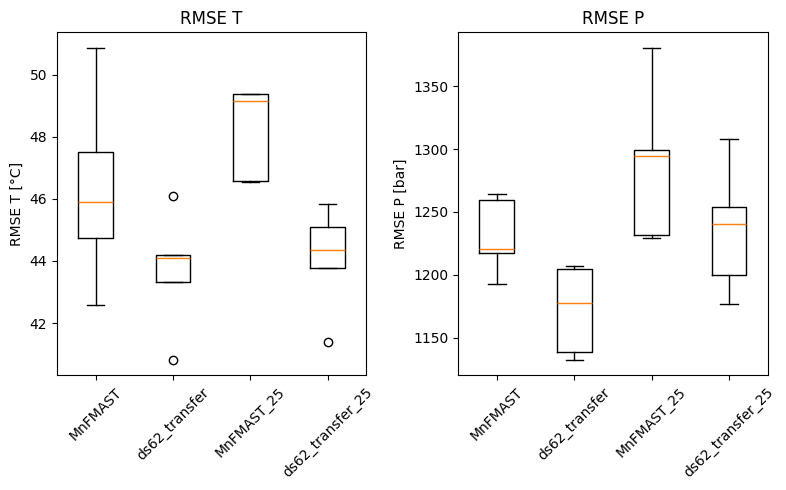

In [6]:
# clalculate RMSE P and T for each model set
RMSE_P_MnFMAST, RMSE_T_MnFMAST = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_MnFMAST)
RMSE_P_ds62, RMSE_T_ds62 = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds62)
RMSE_P_ds62_transfer, RMSE_T_ds62_transfer = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds62_transfer)

RMSE_P_MnFMAST_25, RMSE_T_MnFMAST_25 = kfold_RMSE_PT(val_pt_MnFMAST_25, y_pred_MnFMAST_25)
RMSE_P_ds62_transfer_25, RMSE_T_ds62_transfer_25 = kfold_RMSE_PT(val_pt_MnFMAST_25, y_pred_ds62_transfer_25)


# plot the RMSE for each model set
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].boxplot([RMSE_T_MnFMAST, RMSE_T_ds62_transfer, RMSE_T_MnFMAST_25, RMSE_T_ds62_transfer_25],
               labels=["MnFMAST", "ds62_transfer", "MnFMAST_25", "ds62_transfer_25"])
axs[0].set_ylabel("RMSE T [°C]")
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)
axs[0].set_title("RMSE T")

axs[1].boxplot([RMSE_P_MnFMAST, RMSE_P_ds62_transfer, RMSE_P_MnFMAST_25, RMSE_P_ds62_transfer_25],
               labels=["MnFMAST", "ds62_transfer", "MnFMAST_25", "ds62_transfer_25"])
axs[1].set_ylabel("RMSE P [bar]")
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
axs[1].set_title("RMSE P")

fig.tight_layout()